# 2×2の分割表でのPearsonのカイ二乗検定について

* 黒木玄
* 2025-06-05
* [Google Colabで実行](https://colab.research.google.com/github/genkuroki/public/blob/main/0054/Pearson's%20%CF%87%C2%B2-test%20for%202x2%20table.ipynb)

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

using Pkg

"""すでにPkg.add済みのパッケージのリスト (高速化のために用意)"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    [info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep]]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if !(pkg in _packages_added)
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [2]:
# すでにDistributions.jlとPlots.jlをインストール済みならば `@autoadd` は必要ない。
@autoadd using Distributions
@autoadd using Plots
default(fmt=:png, legendfontsize=12, titlefontsize=12)

rd(x; sigdigits=3) = round(x; sigdigits)
_ecdf(A, x) = count(≤(x), A) / length(A)
safemul(x, y) = x == 0 ? zero(x*y) : isinf(x) ? oftype(x*y, Inf) : x*y
safediv(x, y) = x == 0 ? zero(x/y) : isinf(y) ? zero(x/y) : x/y
pearson_chisq(a, b, c, d) =
    safediv((a+b+c+d)*(a*d-b*c)^2, (a+b)*(c+d)*(a+c)*(b+d))

pearson_chisq (generic function with 1 method)

## Pearsonのカイ二乗統計量に関するシミュレーション

In [3]:
expectval = [16, 24] * [0.3, 0.7]'

2×2 Matrix{Float64}:
 4.8  11.2
 7.2  16.8

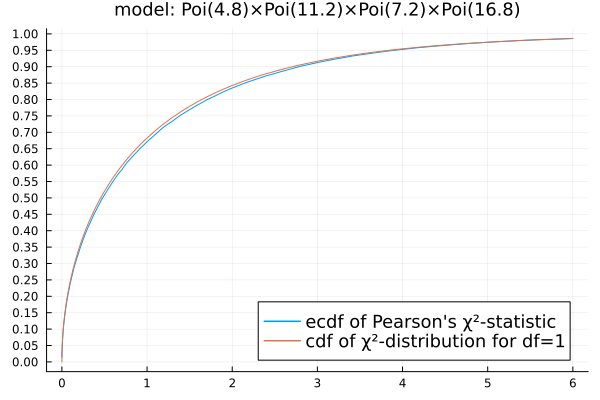

In [4]:
M = (expectval'...,)
poissons = Poisson.(M)
MM = rd.(M)
modelname = "Poi($(MM[1]))×Poi($(MM[2]))×Poi($(MM[3]))×Poi($(MM[4]))"

niters = 10^6
chisq = zeros(niters)
for i in 1:niters
    a, b, c, d = rand.(poissons)
    chisq[i] = pearson_chisq(a, b, c, d)
end

P0 = plot(x -> _ecdf(chisq, x), 0, 6; label="ecdf of Pearson's χ²-statistic")
plot!(x -> cdf(Chisq(1), x); label="cdf of χ²-distribution for df=1")
plot!(ytick=0:0.05:1)
title!("model: $modelname")

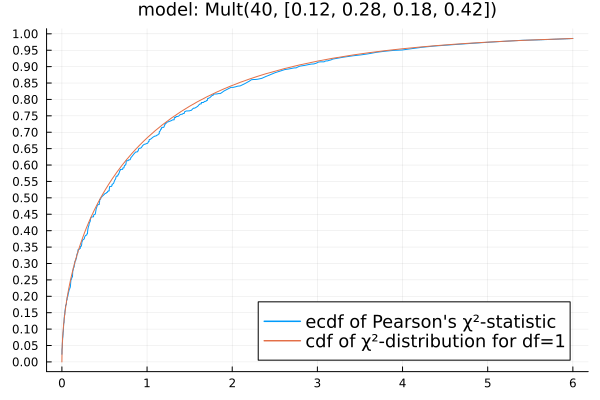

In [5]:
N = round(Int, sum(M))
ps = collect(M)/N
mult = Multinomial(N, ps)
modelname = "Mult($N, $(rd.(ps)))"

niters = 10^6
chisq = zeros(niters)
for i in 1:niters
    a, b, c, d = rand(mult)
    chisq[i] = pearson_chisq(a, b, c, d)
end

P1 = plot(x -> _ecdf(chisq, x), 0, 6; label="ecdf of Pearson's χ²-statistic")
plot!(x -> cdf(Chisq(1), x); label="cdf of χ²-distribution for df=1")
plot!(ytick=0:0.05:1)
title!("model: $modelname")

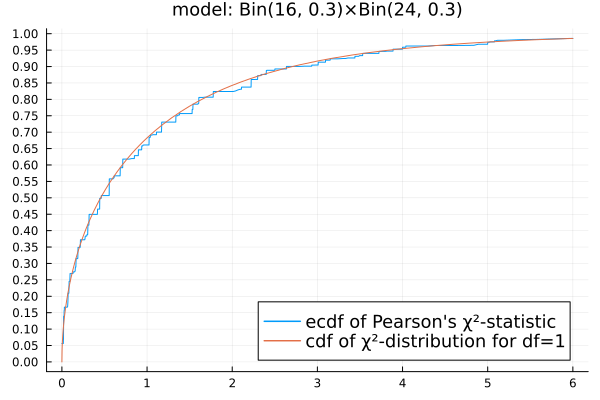

In [6]:
m, n = round(Int, M[1]+M[2]), round(Int, M[3]+M[4])
p, q = M[1]/m, M[3]/n
bin1, bin0 = Binomial(m, p), Binomial(n, q)
modelname = "Bin($m, $p)×Bin($n, $q)"

niters = 10^6
chisq = zeros(niters)
for i in 1:niters
    a, c = rand(bin1), rand(bin0)
    b, d = m-a, n-c
    chisq[i] = pearson_chisq(a, b, c, d)
end

P2 = plot(x -> _ecdf(chisq, x), 0, 6; label="ecdf of Pearson's χ²-statistic")
plot!(x -> cdf(Chisq(1), x); label="cdf of χ²-distribution for df=1")
plot!(ytick=0:0.05:1)
title!("model: $modelname")

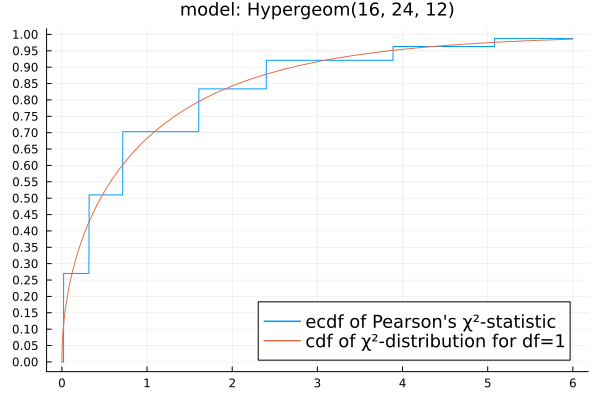

In [7]:
m, n, r = round(Int, M[1]+M[2]), round(Int, M[3]+M[4]), round(Int, M[1]+M[3])
hg = Hypergeometric(m, n, r)
modelname = "Hypergeom($m, $n, $r)"

niters = 10^6
chisq = zeros(niters)
for i in 1:niters
    a = rand(hg)
    c = r-a
    b, d = m-a, n-c
    chisq[i] = pearson_chisq(a, b, c, d)
end

P3 = plot(x -> _ecdf(chisq, x), 0, 6; label="ecdf of Pearson's χ²-statistic")
plot!(x -> cdf(Chisq(1), x); label="cdf of χ²-distribution for df=1")
plot!(ytick=0:0.05:1)
title!("model: $modelname")

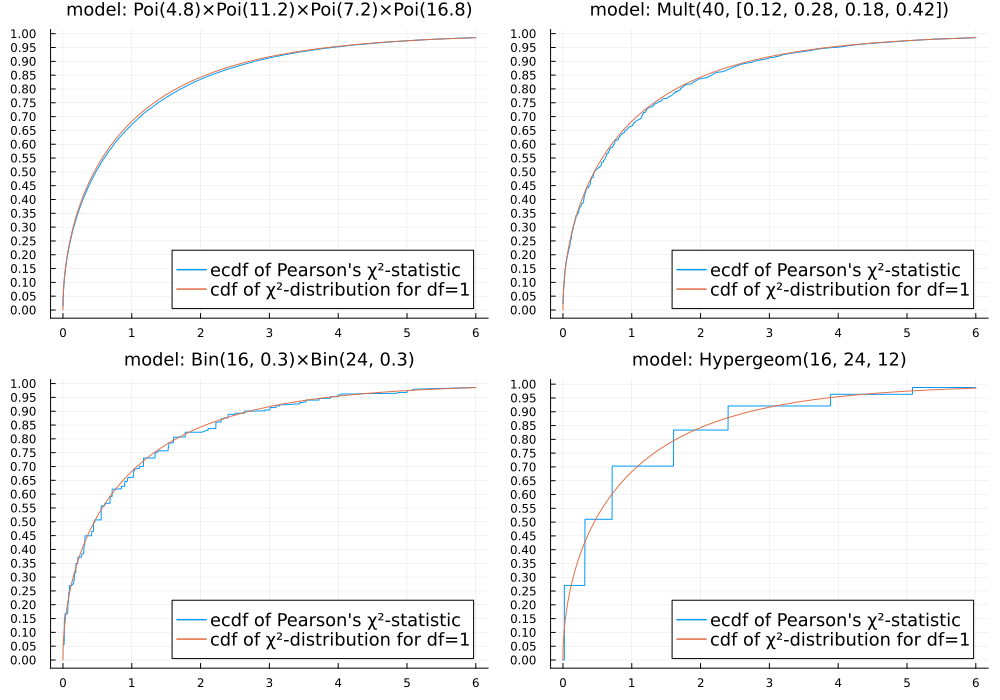

In [8]:
plot(P0, P1, P2, P3; size=(1000, 700), layout=(2, 2))

## Pearsonのカイ二乗検定のP値に関するシミュレーション

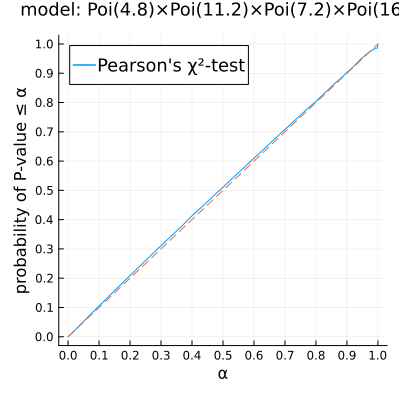

In [9]:
M = vec(([16, 24] * [0.3, 0.7]')')
poissons = product_distribution(Poisson.(M))
MM = rd.(M)
modelname = "Poi($(MM[1]))×Poi($(MM[2]))×Poi($(MM[3]))×Poi($(MM[4]))"

niters = 10^6
pval = zeros(niters)
for i in 1:niters
    a, b, c, d = rand(poissons)
    chisq = pearson_chisq(a, b, c, d)
    pval[i] = ccdf(Chisq(1), chisq)
end

P0 = plot(x -> _ecdf(pval, x), 0, 1; label="Pearson's χ²-test")
plot!(identity; label="", ls=:dash)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of P-value ≤ α")
title!("model: $modelname")
plot!(size=(400, 400))

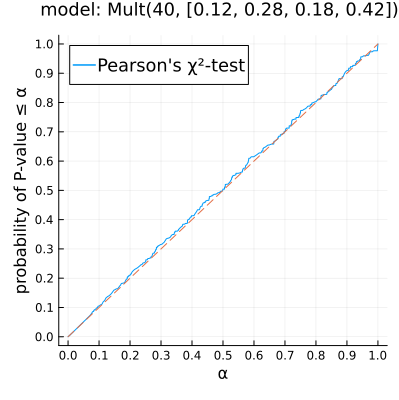

In [10]:
N = round(Int, sum(M))
ps = M/N
mult = Multinomial(N, ps)
modelname = "Mult($N, $(rd.(ps))))"

niters = 10^6
pval = zeros(niters)
for i in 1:niters
    a, b, c, d = rand(mult)
    chisq = pearson_chisq(a, b, c, d)
    pval[i] = ccdf(Chisq(1), chisq)
end

P1 = plot(x -> _ecdf(pval, x), 0, 1; label="Pearson's χ²-test")
plot!(identity; label="", ls=:dash)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of P-value ≤ α")
title!("model: $modelname")
plot!(size=(400, 400))

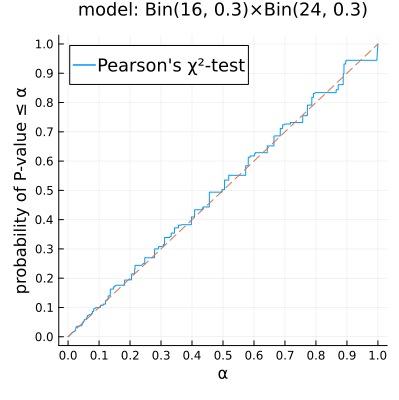

In [11]:
m, n = round(Int, M[1]+M[2]), round(Int, M[3]+M[4])
p, q = M[1]/m, M[3]/n
bin1, bin0 = Binomial(m, p), Binomial(n, q)
modelname = "Bin($m, $p)×Bin($n, $q)"

niters = 10^6
pval = zeros(niters)
for i in 1:niters
    a, c = rand(bin1), rand(bin0)
    b, d = m-a, n-c
    chisq = pearson_chisq(a, b, c, d)
    pval[i] = ccdf(Chisq(1), chisq)
end

P2 = plot(x -> _ecdf(pval, x), 0, 1; label="Pearson's χ²-test")
plot!(identity; label="", ls=:dash)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of P-value ≤ α")
title!("model: $modelname")
plot!(size=(400, 400))

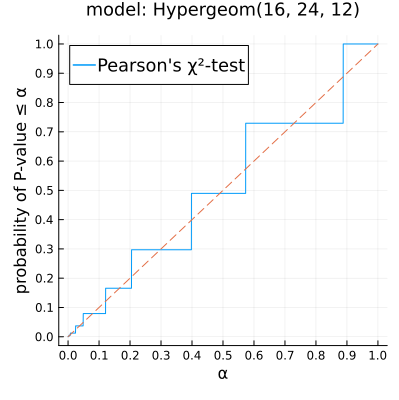

In [12]:
m, n, r = round(Int, M[1]+M[2]), round(Int, M[3]+M[4]), round(Int, M[1]+M[3])
hg = Hypergeometric(m, n, r)
modelname = "Hypergeom($m, $n, $r)"

niters = 10^6
pval = zeros(niters)
for i in 1:niters
    a = rand(hg)
    c = r-a
    b, d = m-a, n-c
    chisq = pearson_chisq(a, b, c, d)
    pval[i] = ccdf(Chisq(1), chisq)
end

P3 = plot(x -> _ecdf(pval, x), 0, 1; label="Pearson's χ²-test")
plot!(identity; label="", ls=:dash)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of P-value ≤ α")
title!("model: $modelname")
plot!(size=(400, 400))

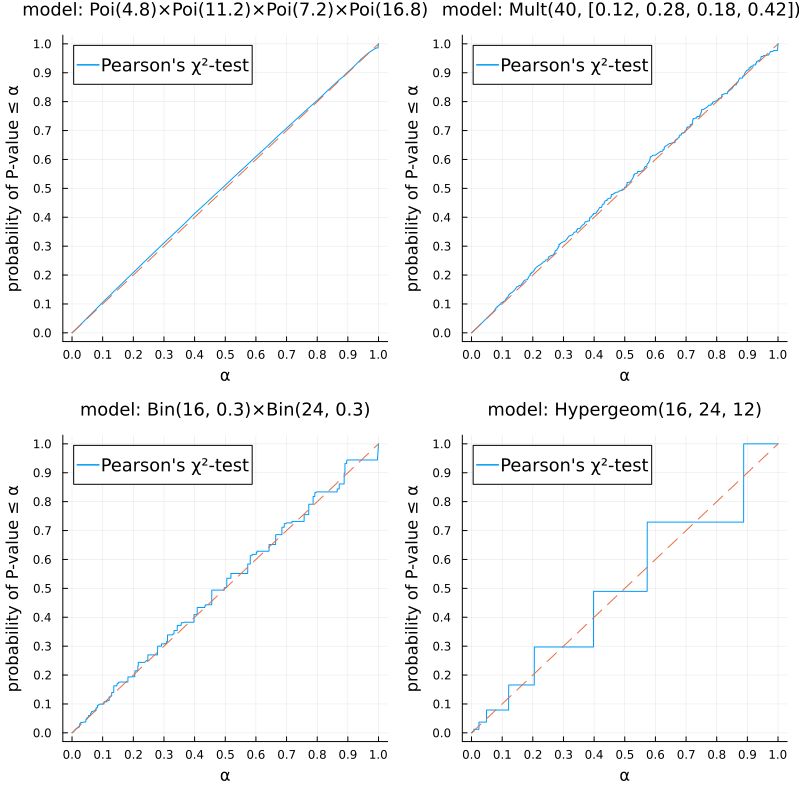

In [13]:
plot(P0, P1, P2, P3; size=(800, 800), layout=(2, 2))

以上のグラフを見れば、4種類のモデルにおける独立性の帰無仮説の下で、Pearsonのカイ二乗検定のP値は一様分布(累積分布関数が45度線)に近似的に従うことがわかる。

## リスク比のカイ二乗検定のP値関数

独立性の帰無仮説単体のカイ二乗検定のP値を求めても、どの程度独立でないかの推定をできない。

この欠点は例えばリスク比RRに関する仮説 RR = ρ (ここでρは仮説値)のP値を構成し、仮説値 ρ を動かしてP値をプロットすれば解消される。

モデルが Bin(m,p)×Bin(n,q) のときのリスク比の定義は RR = p/q である。

In [14]:
_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

pvalue_rr_pearson_chisq (generic function with 1 method)

_riskratiohat(a, b, c, d) = 0.5
pvalue_rr_pearson_chisq(a, b, c, d; ρ = 1) = 0.11384629800665803


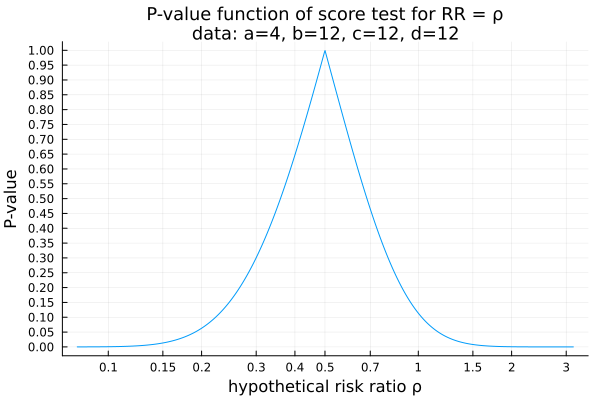

In [15]:
a, b, c, d = 4, 12, 12, 12
@show _riskratiohat(a, b, c, d)
@show pvalue_rr_pearson_chisq(a, b, c, d; ρ=1)

logρs = range(-1.1, 0.5, 1000)
ρs = 10.0 .^ logρs
xtick = Any[0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 1.5, 2, 3]
xtick = (xtick, string.(xtick))
plot(ρs, ρ -> pvalue_rr_pearson_chisq(a, b, c, d; ρ); label="")
plot!(xscale=:log10)
plot!(; xtick, ytick=0:0.05:1)
plot!(xguide="hypothetical risk ratio ρ", yguide="P-value")
title!("P-value function of score test for RR = ρ\ndata: a=$a, b=$b, c=$c, d=$d")

このP値は、2つの二項分布の直積モデルなどの下での、仮説 RR = ρ とデータの値 a=4, b=12, c=12, d=12 の相性の良さ(compatibility)を表す。このグラフを見れば、そのデータの値と最も相性が良い仮説は RR = 0.5 であることや、そのデータの値と仮説 RR = 0.1 や仮説 RR = 2 との相性が非常に悪いことがわかる。

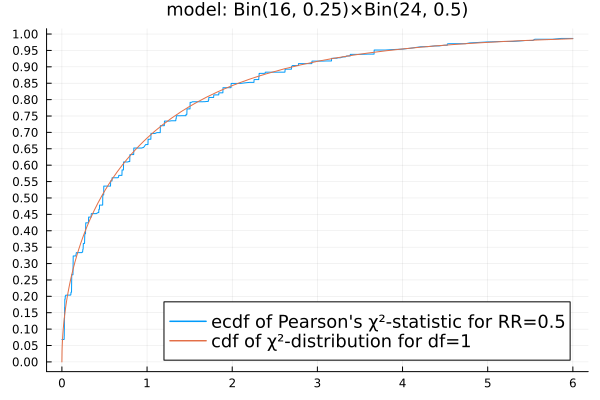

In [16]:
m, n = 16, 24
p, q = 4/16, 12/24
RR = p/q
bin1, bin0 = Binomial(m, p), Binomial(n, q)
modelname = "Bin($m, $p)×Bin($n, $q)"

niters = 10^6
chisq = zeros(niters)
for i in 1:niters
    a, c = rand(bin1), rand(bin0)
    b, d = m-a, n-c
    chisq[i] = chisqstat_rr(a, b, c, d; ρ=RR)
end

P2 = plot(x -> _ecdf(chisq, x), 0, 6; label="ecdf of Pearson's χ²-statistic for RR=$RR")
plot!(x -> cdf(Chisq(1), x); label="cdf of χ²-distribution for df=1")
plot!(ytick=0:0.05:1)
title!("model: $modelname")

以上のように RR = ρ の場合に拡張されたカイ二乗統計量は RR = ρ のとき近似的に自由度1のカイ二乗分布に従う。

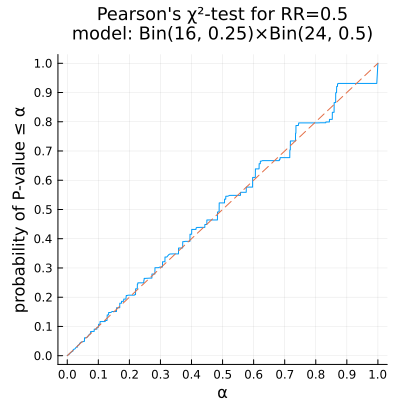

In [17]:
m, n = 16, 24
p, q = 4/16, 12/24
RR = p/q
bin1, bin0 = Binomial(m, p), Binomial(n, q)
modelname = "Bin($m, $p)×Bin($n, $q)"

niters = 10^6
pval = zeros(niters)
for i in 1:niters
    a, c = rand(bin1), rand(bin0)
    b, d = m-a, n-c
    chisq = chisqstat_rr(a, b, c, d; ρ=RR)
    pval[i] = ccdf(Chisq(1), chisq)
end

P1 = plot(x -> _ecdf(pval, x), 0, 1; label="")
plot!(identity; label="", ls=:dash)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="α", yguide="probability of P-value ≤ α")
title!("Pearson's χ²-test for RR=$RR\nmodel: $modelname")
plot!(size=(400, 420))

以上のグラフを見れば、リスク比が1とは限らない RR = ρ の場合にPearsonのカイ二乗検定のP値を拡張できていることがわかる。